#### **This notebook creates features for users**

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import sys
import os

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as viz_hp
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.pandas_helper as pd_hp
import helper.twitter_helper as twitter_hp

import torch

/N/slate/potem/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### **Mean Embedding testing**

In [ ]:
importlib.reload(config_hp)

config = config_hp.config()

embedding_path = config['EMBEDDINGS_PATH']
mean_embedding_user = embedding_path['mean_embedding_user']

df_mean = pd.read_pickle(mean_embedding_user)

In [4]:
df_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123831 entries, 0 to 1123830
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   replier_userid  1123831 non-null  object
 1   embeddings      1123831 non-null  object
 2   mean_tensor     1123831 non-null  object
dtypes: object(3)
memory usage: 25.7+ MB


#### **Label for tweet and replier**

In [15]:
importlib.reload(config_hp)

config = config_hp.config()

balanced = config['BALANCED']
balanced_pos_replier = balanced['balanced_pos_conversation']

df_pos = pd.read_pickle(balanced_pos_replier)

In [16]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160484 entries, 0 to 2673080
Data columns (total 16 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tweet_text       object 
 1   conversation_id  object 
 2   replier_tweetid  object 
 3   replier_userid   object 
 4   poster_userid    object 
 5   poster_tweetid   object 
 6   tweet_time       object 
 7   tweet_language   object 
 8   replier_label    int64  
 9   year             object 
 10  campaign         object 
 11  tweet_label      int64  
 12  tweet_time_year  object 
 13  common           float64
 14  id               object 
 15  username         object 
dtypes: float64(1), int64(2), object(13)
memory usage: 280.2+ MB


In [17]:
# df_pos.loc[df_pos['replier_label'] == 0].info()


grps = df_pos.groupby(['replier_userid', 'replier_label'])
df_grps = pd.DataFrame(grps.groups.keys(), columns=['replier_userid', 'replier_label'])

In [18]:
df_grps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881918 entries, 0 to 881917
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   replier_userid  881918 non-null  object
 1   replier_label   881918 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ MB


In [20]:
df_grps.loc[df_grps['replier_label'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7670 entries, 0 to 7669
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   replier_userid  7670 non-null   object
 1   replier_label   7670 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 179.8+ KB


In [21]:
df_merge = df_mean[['replier_userid', 'mean_tensor']].merge(df_grps[['replier_userid', 'replier_label']],
              left_on=['replier_userid'],
              right_on=['replier_userid']
             )

In [22]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881918 entries, 0 to 881917
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   replier_userid  881918 non-null  object
 1   mean_tensor     881918 non-null  object
 2   replier_label   881918 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.9+ MB


In [23]:
df_merge.loc[df_merge['replier_label'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874248 entries, 7670 to 881917
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   replier_userid  874248 non-null  object
 1   mean_tensor     874248 non-null  object
 2   replier_label   874248 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.7+ MB


**7670 positive examples** <br />
**874,248 negative examples** <br />

#### **Save the user features**

In [24]:
importlib.reload(config_hp)

config = config_hp.config()

user_features = config['USER_FEATURES']

emb_features = user_features['emb_features']

df_merge.to_pickle(emb_features)

#### **Load user embedding data**

In [2]:
importlib.reload(config_hp)

config = config_hp.config()

user_features = config['USER_FEATURES']

emb_features = user_features['emb_features']

df_merge = pd.read_pickle(emb_features)

#### **Info on merge data**

In [3]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881918 entries, 0 to 881917
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   replier_userid  881918 non-null  object
 1   mean_tensor     881918 non-null  object
 2   replier_label   881918 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 26.9+ MB


#### **Visualization of embedding**

In [ ]:
def tsne_visualization(df):

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    # Assuming you have your data stored in a numpy array 'X' of shape (n_samples, n_features)
    X = torch.stack(df['mean_tensor'].tolist())
    
    # Create a t-SNE instance
    tsne = TSNE(n_components=2, random_state=42)
    print(X.shape)
    
    X = torch.squeeze(X)
    
    print(X.shape)


    # Apply t-SNE to your data
    X_tsne = tsne.fit_transform(X)

    labels = df['replier_label']
    # Plot the t-SNE visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                c=labels, cmap='viridis')
    plt.colorbar(label='Labels')

    plt.title("t-SNE Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

    
# X = torch.stack(df_merge['mean_tensor'].tolist())

tsne_visualization(df_merge)

torch.Size([881918, 1, 768])
torch.Size([881918, 768])


#### **Test regression model with embeddings**

In [3]:
df_merge['mean_tensor'][0][0].shape

torch.Size([768])

In [4]:
df_merge['mean_tensor'] = df_merge['mean_tensor'].apply(lambda x: torch.squeeze(x))

In [5]:
df_merge.head()

,replier_userid,mean_tensor,replier_label
0,14596653,"[tensor(-0.0261), tensor(-0.4502), tensor(-0.1...",1
1,17471204,"[tensor(-0.2698), tensor(-0.3507), tensor(0.08...",1
2,22088672,"[tensor(-0.0125), tensor(-0.2361), tensor(-0.0...",1
3,25481010,"[tensor(-0.3391), tensor(-0.4503), tensor(-0.0...",1
4,26337604,"[tensor(-0.0735), tensor(-0.2688), tensor(-0.1...",1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

#### **Logistic regression**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

In [29]:
def run_model(df,
              columns_not_include=['list_age'],
              model_type='random', 
              pca=False,
              y_column = 'tweet_label'
             ):
    '''
    Trains the model and prints the result
    :param df: Dataframe
    :param model_type: Type of model
    :param pca: Whether to do PCA or not
    :param columns_not_include: columns to not include
    '''
    print(df.columns)
          
    columns_not_include.extend(
        ['poster_tweetid','tweet_label', 'replier_userid', 'replier_label'])
    
    columns_to_keep = list(set(df.columns) - set(columns_not_include))
    
    print('Columns to keep :', columns_to_keep)
    
    X = torch.stack(df[columns_to_keep[0]].tolist())
    X = X[:, :100] 
    print(X.shape)
    y = df[y_column]

    #PCA 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    indices = df.index
    
    if pca == True:
        print('here')
        pca = PCA()

        # Fit the PCA object to the data and transform the data
        X = pca.fit_transform(X)
        print('After PCA shape ', X.shape)

    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,
                                                                                     y,
                                                                                     indices,
                                                        # random_state=104, 
                                                        stratify=y,
                                                        test_size=0.20, 
                                                        shuffle=True)

    print('Xtrain: ', len(X_train))
    print('Xtrain shape: ', X_train.shape)
    print('Xtest: ', len(X_test))
    print('Ytrain: ', len(y_train))
    print('Ytest: ', len(y_test))

    if model_type == 'logistic':
        model = LogisticRegression(random_state=0)

    if model_type == 'random':
        model = RandomForestClassifier(n_estimators=100, 
                                       # random_state=42
                                      )

    model.fit(X_train, y_train)
    
    print(model.score(X_train, y_train))

    y_pred = model.predict(X_test)

    result = classification_report(y_test, y_pred, labels=[0,1])

    print(result)
    
    #Cross validation
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = round(scores.mean(), 2)
    std_score = round(scores.std(), 2)
    
    print(f'Cross validation: mean {mean_score} accuracy with a standard deviation of {std_score}')
    
    #feature importance
    if model_type == 'random' and pca == False:
        importances = model.feature_importances_
        df_imp = pd.DataFrame({'Feature': columns_to_keep, 
                                    'Importance': model.feature_importances_})
        df_imp = df_imp.sort_values('Importance', 
                                         ascending=False).set_index('Feature')
        print(df_imp)

    #ROC curve
    lr_probs = model.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, lr_probs[:, 1])
    
    # Compute the AUC score
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', 
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', 
             lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    from sklearn.metrics import precision_recall_curve

    # y_true and y_scores are the true labels and predicted scores, respectively
    precision, recall, thresholds = precision_recall_curve(y_test,
                                                        lr_probs[:, 1])

    # plot the precision-recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    df_pred = df.loc[indices_test]
    df_pred['pred'] = y_pred
    
    return df_pred


Index(['replier_userid', 'mean_tensor', 'replier_label'], dtype='object')
Columns to keep : ['mean_tensor']
torch.Size([881918, 100])
here
After PCA shape  (881918, 100)
Xtrain:  705534
Xtrain shape:  (705534, 100)
Xtest:  176384
Ytrain:  705534
Ytest:  176384
0.9996017201155437
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    174850
           1       0.78      0.02      0.05      1534

    accuracy                           0.99    176384
   macro avg       0.88      0.51      0.52    176384
weighted avg       0.99      0.99      0.99    176384

Cross validation: mean 0.99 accuracy with a standard deviation of 0.0


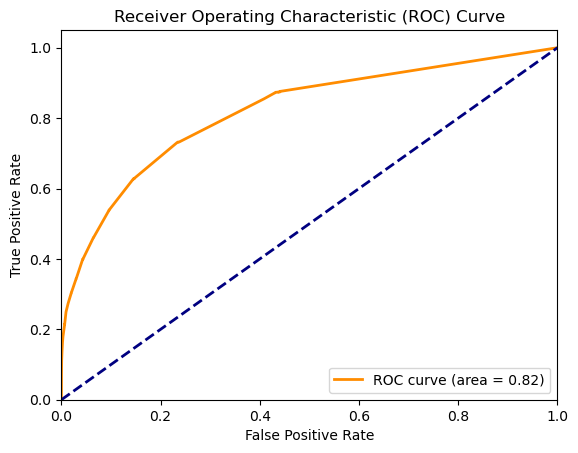

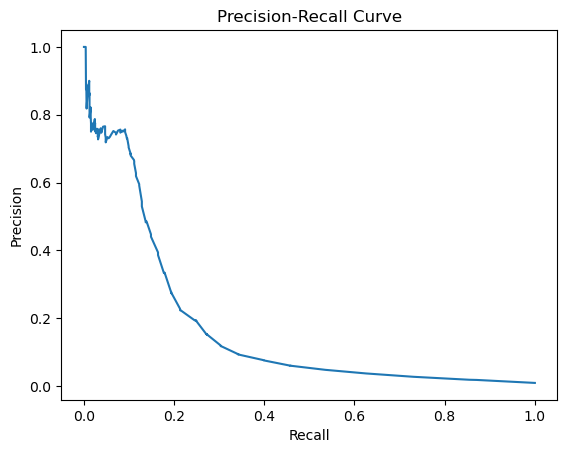

,replier_userid,mean_tensor,replier_label,pred
534674,493502775,"[tensor(-0.1137), tensor(-0.1963), tensor(0.09...",0,0
621282,738963363775053824,"[tensor(-0.0079), tensor(0.0143), tensor(-0.15...",0,0
236447,1686569178,"[tensor(-0.1801), tensor(-0.2021), tensor(0.15...",0,0
362455,2936379024,"[tensor(0.1821), tensor(-0.1080), tensor(-0.04...",0,0
202875,1402924772,"[tensor(0.0862), tensor(-0.3501), tensor(0.163...",0,0
...,...,...,...,...
392791,3150534973,"[tensor(0.0433), tensor(-0.3802), tensor(-0.60...",0,0
287690,2363174301,"[tensor(-0.4861), tensor(-0.1955), tensor(-0.2...",0,0
223323,1573499569,"[tensor(0.5213), tensor(0.3147), tensor(-0.583...",0,0
26299,1007421779147620352,"[tensor(0.1007), tensor(-0.3659), tensor(0.012...",0,0


In [30]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

run_model(df_merge,
                  columns_not_include=[],
                   model_type='random', 
                  pca=True,
                  y_column = 'replier_label'
                 )

#### **Test with Kmeans**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnClassifier = KNeighborsClassifier(n_neighbors = 5, 
                                     metric = 'cosine', )
                                     
y_column = 'replier_label'  
print(df_merge['replier_label'].unique())

#Testing purpose
# df_test = df_merge.sample(n=7000)
# print(df_test['replier_label'].unique())
# X = torch.stack(df_test['mean_tensor'].tolist())

#Real expriment
df_test = df_merge
X = torch.stack(df_test['mean_tensor'].tolist())
X = X[:, :100] 
print(X.shape)
y = df_test[y_column]

#PCA 
scaler = StandardScaler()
X = scaler.fit_transform(X)
indices = df_test.index

print('here')
pca = PCA()

# Fit the PCA object to the data and transform the data
X = pca.fit_transform(X)
print('After PCA shape ', X.shape)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,
                                                                                 y,
                                                                                 indices,
                                                    # random_state=104, 
                                                    stratify=y,
                                                    test_size=0.20, 
                                                    shuffle=True)

print('Xtrain: ', len(X_train))
print('Xtrain shape: ', X_train.shape)
print('Xtest: ', len(X_test))
print('Ytrain: ', len(y_train))
print('Ytest: ', len(y_test))


knnClassifier.fit(X_train, y_train)
y_pred = knnClassifier.predict(X_test)
                                     
result = classification_report(y_test,
                               y_pred, 
                               labels=[0,1])

print(result)

#Cross validation
scores = cross_val_score(knnClassifier,
                         X_train, 
                         y_train,
                         cv=5)
mean_score = round(scores.mean(), 2)
std_score = round(scores.std(), 2)

print(f'Cross validation: mean {mean_score} accuracy with a standard deviation of {std_score}')

lr_probs = knnClassifier.predict_proba(X_test)
    

fpr, tpr, thresholds = roc_curve(y_test, lr_probs[:, 1])

# Compute the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(fpr, tpr, color='darkorange', 
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', 
         lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve \n Knearest neighbor \n Reply Embedding')
ax.legend(loc="lower right")
plt.show()

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

fig.savefig(f'{reply_plot_path}/knearest_neighbor_emb.png')